In [1]:
import addfips
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import folium
import pickle
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import pyproj
import collections

%matplotlib inline

#### Bring in the county level species data

In [4]:
spec = pd.read_csv('../data/rare_species_by_county.csv')

In [5]:
spec.head()

,County,Type,Category,Scientific Name,Common Name,Global Rank,State Rank,Fed. Status,State Status,Habitat,Wet Habitat Flag
0,Anderson,Invertebrate Animal,Arachnid,Hesperochernes mirabilis,Southeastern Cave Pseudoscorpion,G5,S3,--,"Rare, Not State Listed",Terrestrial cave obligate; woodrat debris in c...,Upland
1,Anderson,Invertebrate Animal,Mollusc,Cyprogenia stegaria,Fanshell,G1,S1,"LE, XN",E,Medium to large streams and rivers with coarse...,Aquatic
2,Anderson,Vertebrate Animal,Bird,Limnothlypis swainsonii,Swainson's Warbler,G4,S3,--,D,"Mature, rich, damp, deciduous floodplain and s...",Possible
3,Anderson,Vertebrate Animal,Reptile,Ophisaurus attenuatus longicaudus,Eastern Slender Glass Lizard,G5T5,S3,--,D,"Dry upland areas including brushy, cut-over wo...",Upland
4,Anderson,Vertebrate Animal,Bird,Vermivora chrysoptera,Golden-winged Warbler,G4,S3B,--,T,Early successional habitats in foothill region...,Upland


##### Rename columns with no spaces, create a column that makes it easy to sum instances, "summer" and group by County

In [6]:
spec.columns = ['County', 'Type', 'Category', 'Scientific_Name', 'Common_Name', 
               'Global_Rank', 'State_Rank', 'Fed_Status', 'State_Status', 'Habitat', 'Wet_Habitat_Flag']

In [7]:
species_list = spec['Common_Name'].value_counts()

In [8]:
spec['summer'] = 1

In [9]:
allspec_bycounty = spec.groupby(['County']).agg({'summer': sum})

##### Join the geometry from original counties file

#### How many of each of the ranks are we seeing in the whole state?

First, global rank:

In [10]:
spec.Global_Rank

0          G5
1          G1
2          G4
3        G5T5
4          G4
        ...  
4422      G3Q
4423       G5
4424    G5T4?
4425       G5
4426       G1
Name: Global_Rank, Length: 4427, dtype: object

In [11]:
gtype_list = spec.Global_Rank.tolist()

In [12]:
type(gtype_list)

list

In [13]:
collections.Counter(gtype_list)

Counter({'G5': 1098,
         'G1': 433,
         'G4': 602,
         'G5T5': 56,
         'G1G2': 133,
         'G3': 697,
         'G3G4': 297,
         'GNR': 71,
         'G2G3': 253,
         'G4T4': 34,
         'G3G5': 17,
         'G4?T4Q': 11,
         'G2': 267,
         'G3?': 22,
         'G4G5': 138,
         'G3G4T3': 14,
         'G2?': 18,
         'G2Q': 15,
         'G3QT3Q': 17,
         'G5T3Q': 13,
         'G5T4?': 8,
         'G4?': 41,
         'G5T4Q': 5,
         'G5?': 24,
         'G1G2Q': 8,
         'GNRT1': 1,
         'G5T2': 8,
         'G3T2T3': 4,
         'G5T3?': 5,
         'G2G4': 10,
         'G3Q': 8,
         'G1Q': 11,
         'G4G5T4T5': 7,
         'GH': 3,
         'G5T4T5': 5,
         'G3G4T2': 4,
         'G5T3': 4,
         'G4?Q': 7,
         'GU': 2,
         'G4G5T4': 3,
         'G5?T3': 3,
         'G4T2': 3,
         'G2G3Q': 8,
         'G4G5T4?': 7,
         'G4G5T3': 4,
         'G4T3Q': 5,
         'G5T3T5': 1,
         'G3G4

In [14]:
gtype_dict = collections.Counter(gtype_list)

In [15]:
gtype_df = pd.DataFrame.from_dict(gtype_dict, orient = 'index', columns = ['count'])

In [16]:
gtype_df = gtype_df.sort_values(['count'], ascending = False).reset_index()

In [17]:
gtype_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   58 non-null     object
 1   count   58 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [18]:
gtype_df = gtype_df.head(9)

In [19]:
gtype_df = gtype_df.sort_values(['count'])

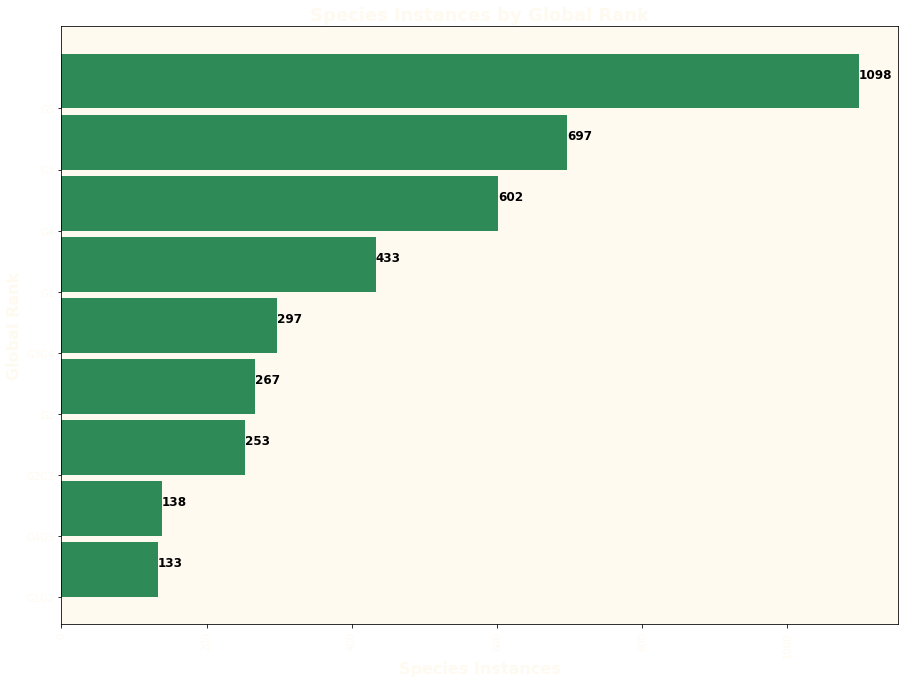

In [20]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = gtype_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('Global Rank', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by Global Rank', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(color = 'floralwhite')

for i in plt.barh('index', 'count', data = gtype_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');

Next, State rank:

In [21]:
stype_list = spec.State_Rank.tolist()

In [22]:
stype_dict = collections.Counter(stype_list)

In [23]:
stype_df = pd.DataFrame.from_dict(stype_dict, orient = 'index', columns = ['count'])

In [24]:
stype_df = stype_df.sort_values(['count'], ascending = False).reset_index(inplace = False)

In [25]:
stype_df = stype_df.sort_values(['count'], ascending = False).reset_index(inplace = False)

In [26]:
stype_df

,level_0,index,count
0,0,S1,1401
1,1,S2,1208
2,2,S3,777
3,3,S2S3,350
4,4,S1S2,337
5,5,S3S4,85
6,6,SNR,73
7,7,S3B,37
8,8,S4,37
9,9,S2?,27


In [27]:
stype_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   level_0  23 non-null     int64 
 1   index    23 non-null     object
 2   count    23 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 680.0+ bytes


In [28]:
stype_df['level_0'] = stype_df['level_0'].astype(int)

In [29]:
stype_df = stype_df[(stype_df['level_0'].isin([0, 1, 2, 8, 4, 3, 5]))]

In [30]:
stype_df = stype_df.sort_values(['count'])

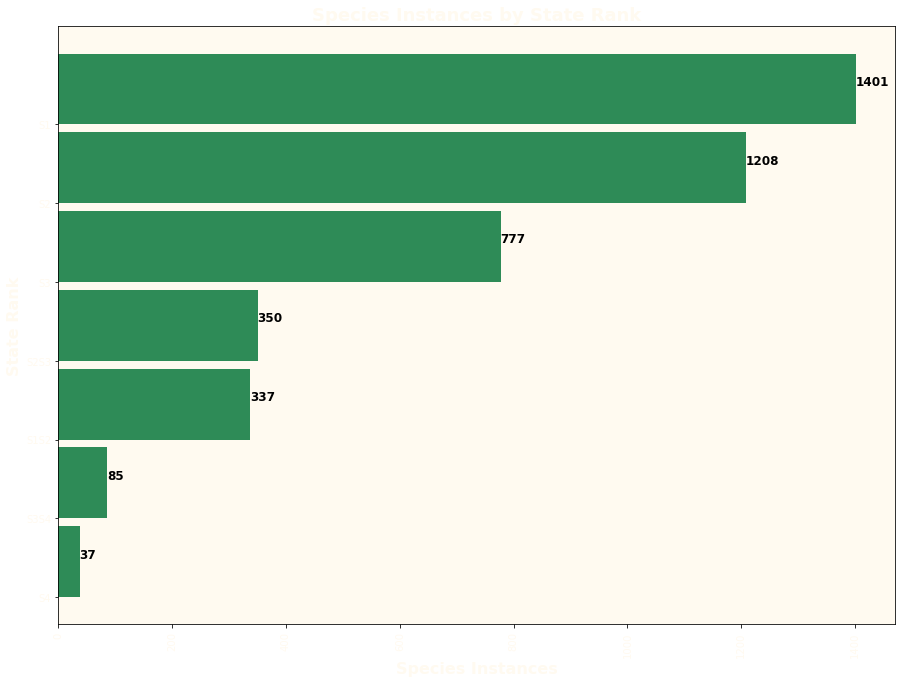

In [31]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = stype_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('State Rank', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by State Rank', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(color = 'floralwhite')

for i in plt.barh('index', 'count', data = stype_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');

Same process but with Federal Status:

In [32]:
fstat_list = spec.Fed_Status.tolist()

In [33]:
fstat_dict = collections.Counter(fstat_list)

In [34]:
fstat_df = pd.DataFrame.from_dict(fstat_dict, orient = 'index', columns = ['count'])

In [35]:
fstat_df = fstat_df.sort_values(['count']).reset_index(inplace = False)

In [36]:
fstat_df = fstat_df.sort_values(['count']).reset_index(inplace = False)

In [37]:
fstat_df

,level_0,index,count
0,0,SC,1
1,1,SAT,2
2,2,C,4
3,3,"LT, XN",6
4,4,"LT,XN",20
5,5,"LE,XN",20
6,6,DM,21
7,7,No Status,48
8,8,LT,113
9,9,"LE, XN",170


In [38]:
fstat_df = fstat_df[(fstat_df['level_0'].isin([8, 10]))]

In [39]:
fstat_df

,level_0,index,count
8,8,LT,113
10,10,LE,339


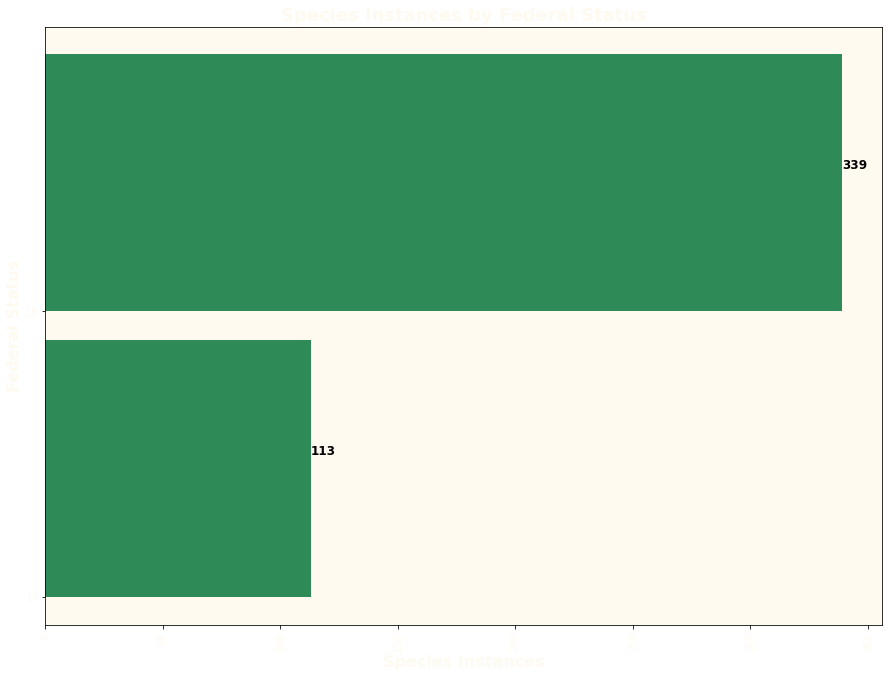

In [40]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = fstat_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('Federal Status', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by Federal Status', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(color = 'floralwhite')

for i in plt.barh('index', 'count', data = fstat_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');

Next: Type

In [78]:
type_list = spec.Type.tolist()

In [79]:
type_dict = collections.Counter(type_list)

In [80]:
type_df = pd.DataFrame.from_dict(type_dict, orient = 'index', columns = ['count'])

In [98]:
type_df = type_df.sort_values(['count']).reset_index(inplace = False)

In [99]:
type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8 non-null      object
 1   count   8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


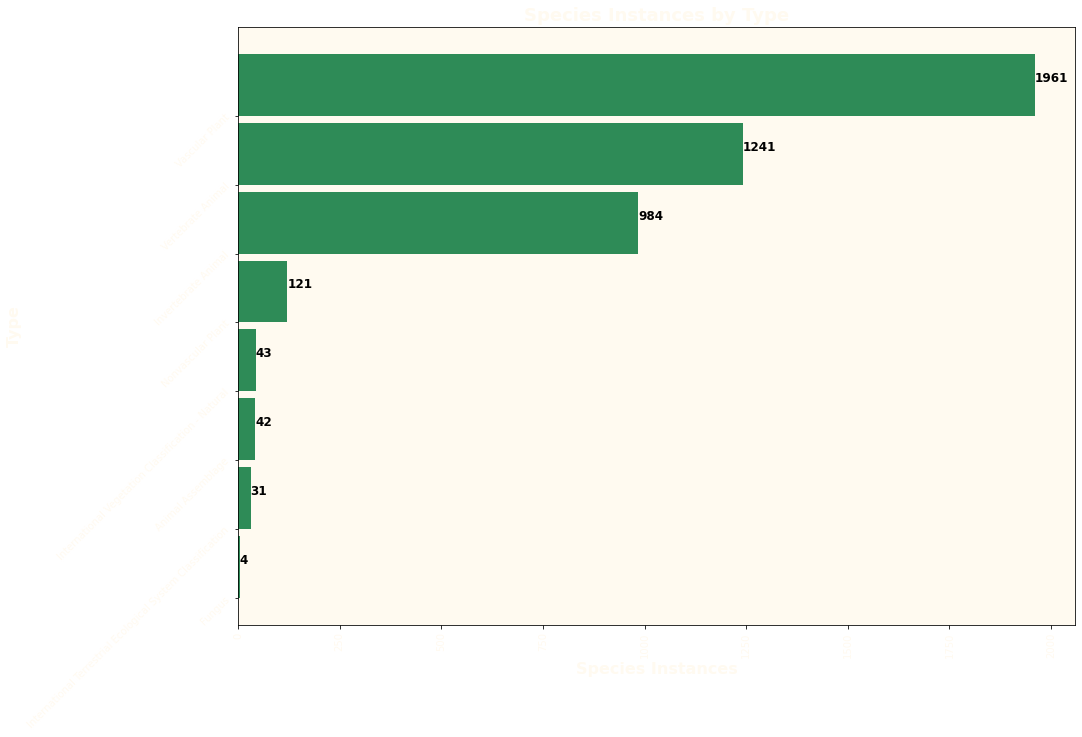

In [134]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = type_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('Type', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by Type', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(rotation = 45, color = 'floralwhite')

for i in plt.barh('index', 'count', data = type_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');

Now with Category:

In [106]:
cat_list = spec.Category.tolist()

In [107]:
cat_dict = collections.Counter(cat_list)

In [108]:
cat_df = pd.DataFrame.from_dict(cat_dict, orient = 'index', columns = ['count'])

In [109]:
cat_df = cat_df.sort_values(['count']).reset_index(inplace = False)

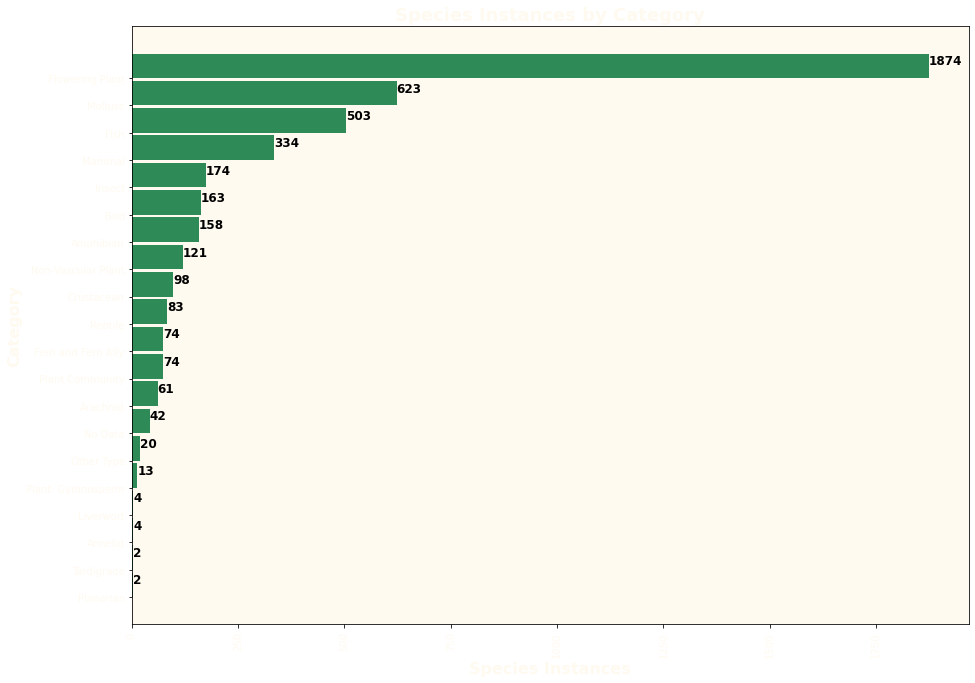

In [135]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = cat_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('Category', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by Category', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(color = 'floralwhite')

for i in plt.barh('index', 'count', data = cat_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');

Now, habitat types:

In [44]:
hab_list = spec.Wet_Habitat_Flag.tolist()

In [45]:
hab_dict = collections.Counter(hab_list)

In [46]:
hab_df = pd.DataFrame.from_dict(hab_dict, orient = 'index', columns = ['count'])

In [47]:
hab_df = hab_df.sort_values(['count']).reset_index(inplace = False)

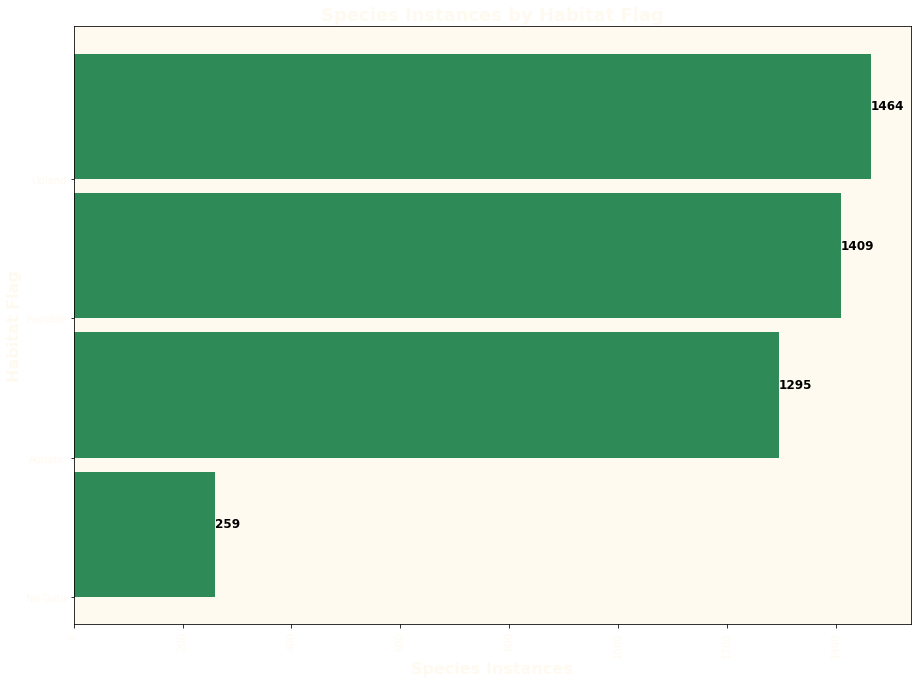

In [48]:
#plot:

plt.figure(figsize = (15, 11))
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.barh('index', 'count', data = hab_df, color = 'seagreen', align = 'edge', height = 0.9)
plt.xlabel('Species Instances', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.ylabel('Habitat Flag', fontweight = 'bold', fontsize = 16, color = 'floralwhite')
plt.title('Species Instances by Habitat Flag', fontweight = 'bold', fontsize = 18, color = 'floralwhite')
plt.xticks(rotation = 90, color = 'floralwhite')
plt.yticks(color = 'floralwhite')

for i in plt.barh('index', 'count', data = hab_df, color = 'seagreen', align = 'edge', height = 0.9):  
    plt.text(i.get_width()-0.0001*i.get_width(), i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight = 'bold',
             color ='black');